In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import re
import pandas as pd
import numpy as np
import random
from PIL import Image
from torchvision import transforms
batch_size = 128

In [2]:
#数据预处理
root_dir = './classify-leaves/'
test_dir = './classify-leaves/test.csv'
train_val_dir = './classify-leaves/train.csv'
# 读取csv文件
def load_annotations(data_dir):
    data = pd.read_csv(data_dir)
    data_array = np.array(data)
    data_info = data_array.tolist()
    return data_info
data_info=load_annotations(train_val_dir)
random.shuffle(data_info)
# # 将数据和标签分开放在独立的list中
image_names = [i[0] for i in data_info]
labels = [i[1] for i in data_info]
image_path = [root_dir+i for i in image_names]
# 18353
test_data = [root_dir+i[0] for i in load_annotations(test_dir)]
print('test data:\t',len(test_data))
print('train and val data:\t',len(image_path))
train_data = image_path[:len(image_path)//5*4]
train_label = labels[:len(labels)//5*4]
val_data = image_path[len(image_path)//5*4:]
val_label = labels[len(labels)//5*4:]

test data:	 8800
train and val data:	 18353


In [3]:
# 数据集创建
class MyDataset(Dataset):
    def __init__(self, image_path, labels, transform=None):
        self.image_path = image_path
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        img = Image.open(self.image_path[index])
        pil = transforms.PILToTensor()
        img = pil(img).type(dtype=torch.float32)/255
        # print(img.shape)
        pil = transforms.Normalize(
            mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        img = pil(img)
        label = self.labels[index]
        return img, label

    def normalization(img):
        channel_mean = torch.zeros(3)
        channel_std = torch.zeros(3)
        C,H,W = img.shape


train_dataset = MyDataset(train_data, train_label)
val_dataset = MyDataset(val_data, val_label)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [62]:
img,label = next(iter(train_dataloader))
# print(img.dtype)
# print(img.shape)
print(img[0].shape)
img.view(128,3,-1).shape

torch.Size([3, 224, 224])


torch.Size([128, 3, 50176])

In [4]:
# 网络架构
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)


    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)


b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

training on cuda:0


AttributeError: 'tuple' object has no attribute 'to'

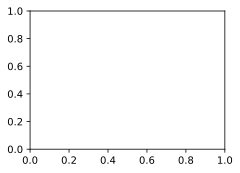

In [5]:
lr,num_epochs = 0.05,10
# train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_dataloader,val_dataloader,num_epochs,lr,d2l.try_gpu())

In [5]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
# d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())